In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wind-energy-germany/germany-wind-energy.csv


# Load data

- Homepage [here](https://www.kaggle.com/aymanlafaz/wind-energy-germany)

The columns in the dataset are :

- utc_timestamp : Time in UTC
- wind_generation : Daily wind production in MW
- wind_capacity : Electrical capacity of wind in MW
- temperature : Daily Temperature in degrees CThe columns in the dataset are :

In [2]:
raw = pd.read_csv('../input/wind-energy-germany/germany-wind-energy.csv')
print(raw.shape)
raw.head()

(1094, 4)


,utc_timestamp,wind_generation_actual,wind_capacity,temperature
0,2017-01-01 00:00:00+00:00,291760.0,37149.130,-2.117
1,2017-01-02 00:00:00+00:00,295097.0,37152.125,-1.154
2,2017-01-03 00:00:00+00:00,666170.0,37155.208,-0.239
3,2017-01-04 00:00:00+00:00,686581.0,37160.125,0.620
4,2017-01-05 00:00:00+00:00,261759.0,37163.542,-3.908


## Preprocessing

In [3]:
df = (
    raw
    .assign(utc_timestamp = lambda x: x['utc_timestamp'].apply(lambda x: pd.to_datetime(x).tz_localize(None)))
    # This is pointless, the data is at the day level
    # .assign(hour = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).hour))
    .assign(year = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).year))
    .assign(month = lambda x: x['utc_timestamp'].apply(lambda x: pd.Timestamp(x).month))
)

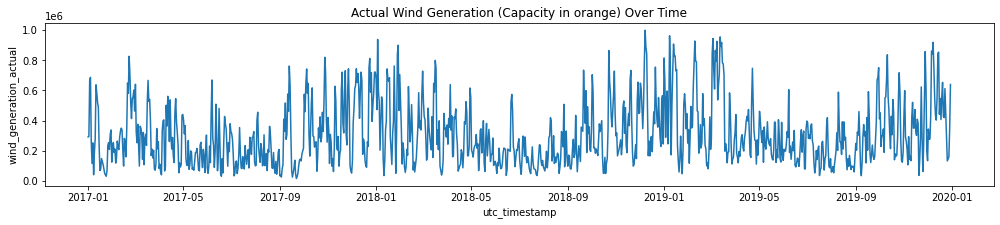

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(17, 3))

sns.lineplot(x='utc_timestamp', y='wind_generation_actual', data=df, ax=ax);
#sns.lineplot(x='utc_timestamp', y='wind_capacity', data=df);
plt.title('Actual Wind Generation (Capacity in orange) Over Time');

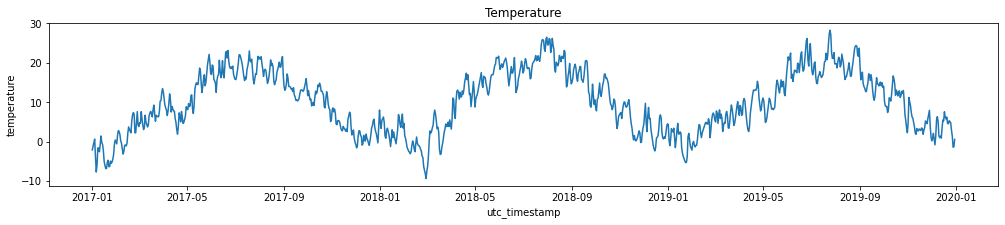

In [5]:
fig, ax = plt.subplots(figsize=(17, 3))

sns.lineplot(x='utc_timestamp', y='temperature', data=df, ax=ax);
plt.title('Temperature');

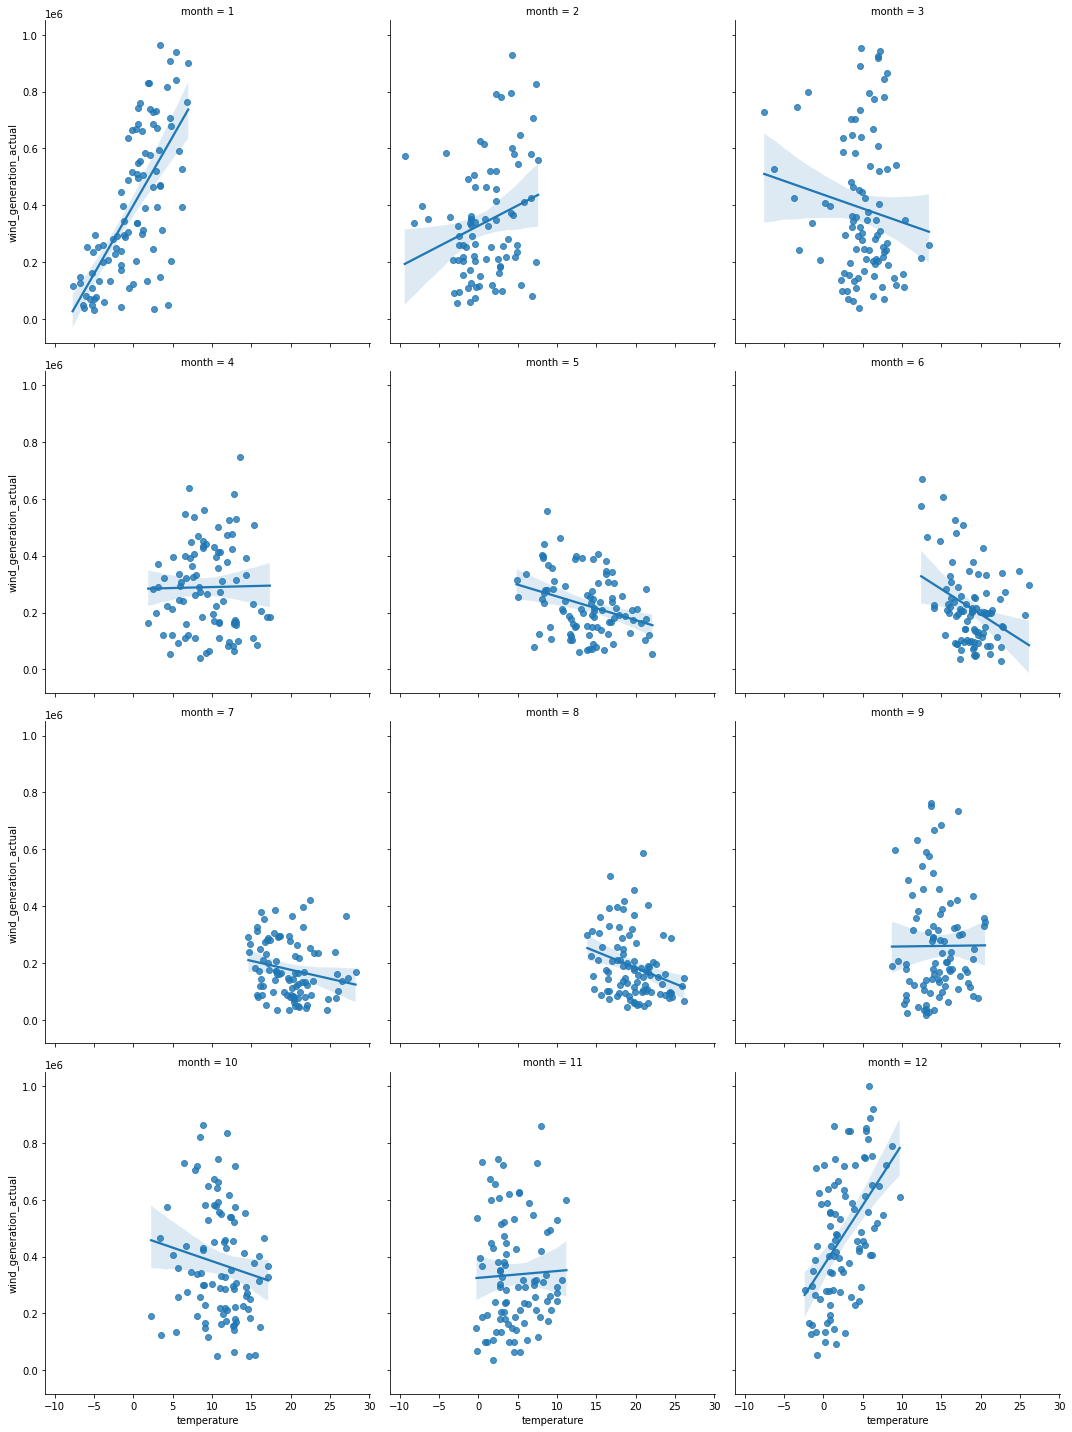

In [6]:
sns.lmplot(
    x='temperature', 
    y='wind_generation_actual', 
    data=df,
    col='month',
    col_wrap=3
);

I wonder if there are times within the day that have a stronger relationship (night, morning, afternoon, evening)

# Approach #1 - linear model (pwr gen = temperature) (rmse = 194,000)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    df[['temperature']], 
    df['wind_generation_actual'], 
    test_size=0.33, 
    random_state=42
)

def build_lm(x, y):
    """ Build a linear model"""
    return (
        LinearRegression()
        .fit(X=x, y=y)
    )

train_model = build_lm(X_train, y_train)

Clearly missing some sort of pattern here

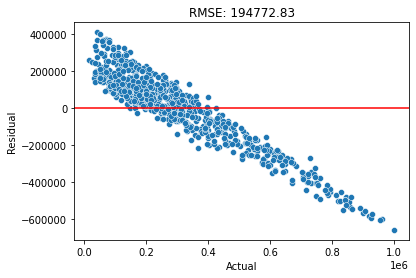

In [8]:
preds = train_model.predict(X_train)
rmse = mean_squared_error(y_train, preds, squared=False)

sns.scatterplot(
    x=y_train,
    y=(preds - y_train),
);
plt.axhline(y=0, color='r');
plt.xlabel('Actual');
plt.ylabel('Residual');
plt.title(f'RMSE: {round(rmse, 2)}');

# Time Series

- Resource [here](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

### (there is some) Investigate Auto-Correlation

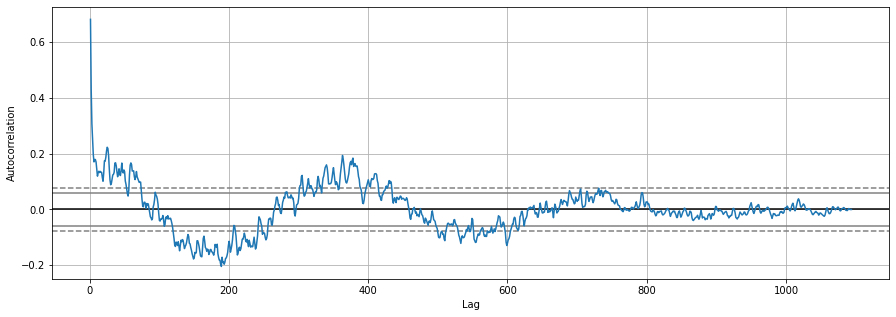

In [9]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(df['wind_generation_actual'], ax = ax);

### Decomposition

In [10]:
df.head()

,utc_timestamp,wind_generation_actual,wind_capacity,temperature,year,month
0,2017-01-01,291760.0,37149.130,-2.117,2017,1
1,2017-01-02,295097.0,37152.125,-1.154,2017,1
2,2017-01-03,666170.0,37155.208,-0.239,2017,1
3,2017-01-04,686581.0,37160.125,0.620,2017,1
4,2017-01-05,261759.0,37163.542,-3.908,2017,1


['nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']


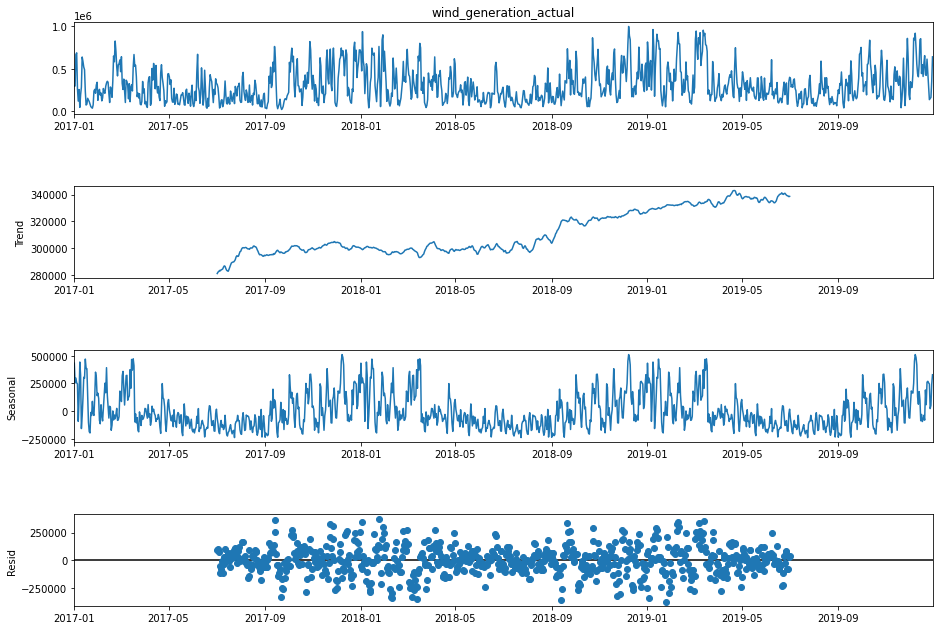

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    df.set_index('utc_timestamp')['wind_generation_actual'], model='additive', 
    period=365
)

print([x for x in dir(result) if not x.startswith('_')])

result.plot();
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(10)

### Autoregression

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


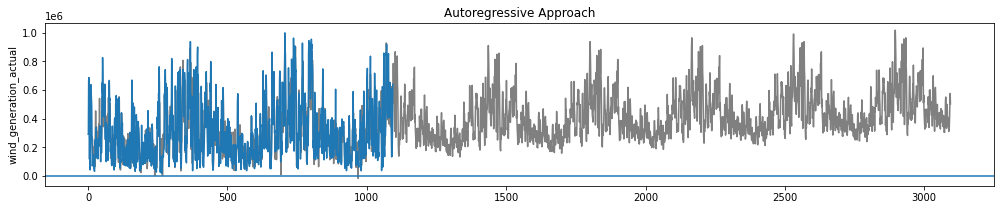

In [12]:
from statsmodels.tsa.ar_model import AutoReg 

model = AutoReg(df['wind_generation_actual'], lags=15, trend='ct', seasonal=15, period=365)
model_fit = model.fit()
yhats = model_fit.predict(0, len(df)+2000)

fig, ax = plt.subplots(figsize=(17, 3))

sns.lineplot(x=list(range(len(yhats))), y=yhats, color='grey', ax=ax);
sns.lineplot(x=list(range(len(df))), y=df['wind_generation_actual'], ax=ax);
plt.axhline(y=0.2);

plt.title('Autoregressive Approach');

def use_ar(dat, nLags):
    model = AutoReg(dat['wind_generation_actual'], lags=nLags)
    model_fit = model.fit()
    return model_fit.predict(0, len(df) - 1)

In [13]:
use_ar(df.head(100), 4)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


0                 NaN
1                 NaN
2                 NaN
3                 NaN
4       526302.158427
            ...      
1089    280585.597686
1090    280585.597686
1091    280585.597686
1092    280585.597686
1093    280585.597686
Length: 1094, dtype: float64

In [14]:
import datetime
df.loc[lambda x: x['utc_timestamp'] >= datetime.datetime(2018, 2, 2)]

,utc_timestamp,wind_generation_actual,wind_capacity,temperature,year,month
397,2018-02-02,351065.0,43116.000,0.806,2018,2
398,2018-02-03,112228.0,43116.000,-0.281,2018,2
399,2018-02-04,252417.0,43116.292,-1.527,2018,2
400,2018-02-05,202820.0,43123.750,-1.948,2018,2
401,2018-02-06,93384.0,43141.292,-2.496,2018,2
...,...,...,...,...,...,...
1089,2019-12-26,132739.0,50424.125,2.790,2019,12
1090,2019-12-27,146590.0,50427.000,1.327,2019,12
1091,2019-12-28,159126.0,50427.292,-1.441,2019,12
1092,2019-12-29,349839.0,50434.750,-1.314,2019,12


In [15]:
dir(model_fit)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ar_lags',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_df_model',
 '_get_robustcov_results',
 '_hold_back',
 '_lag_repr',
 '_max_lag',
 '_n_totobs',
 '_nobs',
 '_params',
 '_use_t',
 'aic',
 'ar_lags',
 'arfreq',
 'bic',
 'bse',
 'conf_int',
 'cov_params',
 'cov_params_default',
 'data',
 'df_model',
 'df_resid',
 'diagnostic_summary',
 'f_test',
 'fittedvalues',
 'forecast',
 'fpe',
 'get_prediction',
 'hqic',
 'initialize',
 'llf',
 'load',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'plot_diagnostics',
 'plot_predict',
 'predict',
 'pvalues',
 'remove_data',
 'resid',
 'roots',
 'save',
 'scale',
 'si

### SARIMAX 